# Stock analysis using Historical Data (LSTM)

In [1]:
#import packages
import pandas as pd
import numpy as np
import pandas_datareader as web
#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

df = web.DataReader('^DJI', data_source='yahoo', start='2008-08-08', end='2016-07-01')
df.reset_index(level=0, inplace=True)
df.tail()


#print the head
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1985,2016-06-27,17355.210938,17063.080078,17355.210938,17140.240234,1387400,17140.240234
1986,2016-06-28,17409.720703,17190.509766,17190.509766,17409.720703,1121900,17409.720703
1987,2016-06-29,17704.509766,17456.019531,17456.019531,17694.679688,1063800,17694.679688
1988,2016-06-30,17930.609375,17711.800781,17712.759766,17929.990234,1330300,17929.990234
1989,2016-07-01,18002.380859,17916.910156,17924.240234,17949.369141,821600,17949.369141


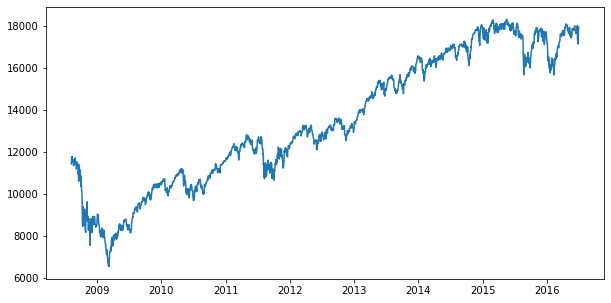

In [2]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Close Price history')

In [3]:
df.shape

(1990, 7)

In [4]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1200,:]
valid = dataset[1200:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [5]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/5
1140/1140 - 20s - loss: 0.0015
Epoch 2/5
1140/1140 - 16s - loss: 5.2023e-04
Epoch 3/5
1140/1140 - 18s - loss: 3.9371e-04
Epoch 4/5
1140/1140 - 19s - loss: 3.2653e-04
Epoch 5/5
1140/1140 - 19s - loss: 2.7617e-04


In [6]:
closing_price

array([[15106.534 ],
       [15182.637 ],
       [15138.376 ],
       [15233.256 ],
       [15231.305 ],
       [15269.4375],
       [15198.727 ],
       [15176.105 ],
       [15194.53  ],
       [15305.633 ],
       [15219.175 ],
       [15214.5   ],
       [15027.894 ],
       [15139.899 ],
       [15111.93  ],
       [14897.759 ],
       [14947.669 ],
       [15178.24  ],
       [15196.755 ],
       [15053.015 ],
       [14903.389 ],
       [15069.748 ],
       [15019.884 ],
       [15099.039 ],
       [15241.026 ],
       [15052.503 ],
       [14677.252 ],
       [14689.139 ],
       [14624.392 ],
       [14722.292 ],
       [14886.103 ],
       [14997.879 ],
       [14872.189 ],
       [14885.333 ],
       [14856.962 ],
       [14905.796 ],
       [15055.539 ],
       [15153.161 ],
       [15212.494 ],
       [15190.899 ],
       [15333.739 ],
       [15355.275 ],
       [15358.647 ],
       [15324.488 ],
       [15340.622 ],
       [15425.633 ],
       [15433.073 ],
       [15425

In [7]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

251.75227078965668

<ipython-input-8-8bf24d1a333e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


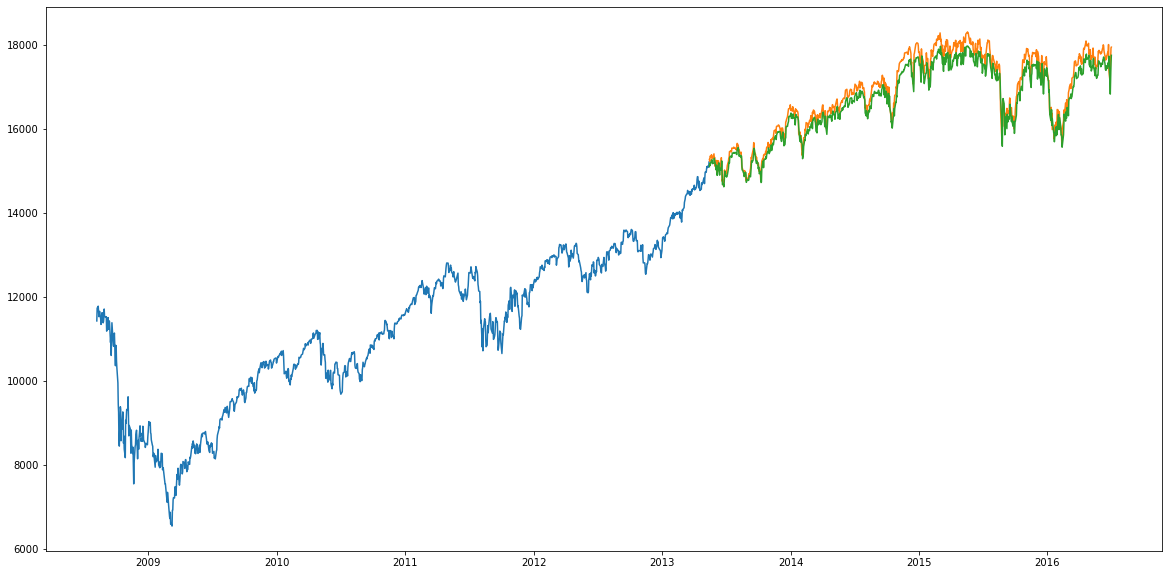

In [8]:
#for plotting
train = new_data[:1200]
valid = new_data[1200:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])